[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Hanifan12/Food-Calories/blob/main/Food_Recognition_20Class.ipynb)

# Import Library

In [1]:
import tensorflow as tf
import os 
import matplotlib.pyplot as plt
import numpy as np
import pathlib

from zipfile import ZipFile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# versioning
print(keras.__version__)
print(tf.__version__)

2.5.0
2.5.0


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Access Dataset

In [4]:
zip_path = '/content/drive/Shareddrives/Dataset/food101_20class.zip'
!cp "{zip_path}" .

In [5]:
!unzip -q food101_20class.zip
!rm food101_20class.zip

In [6]:
train_dir = "/content/food101_20class/Training"
val_dir = "/content/food101_20class/Validation"
train_dir = pathlib.Path(train_dir)
val_dir = pathlib.Path(val_dir)

In [7]:
train_image_count = len(list(train_dir.glob('*/*')))
val_image_count = len(list(val_dir.glob('*/*')))
num_classes = len(list(train_dir.glob('*')))

print('Training images:', train_image_count)
print('Validation images:', val_image_count)
print('Labels:', num_classes)

Training images: 16000
Validation images: 4000
Labels: 20


In [8]:
batch_size = 64
img_height = 224
img_width = 224

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 16000 files belonging to 20 classes.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4000 files belonging to 20 classes.


# Pre-processing

In [11]:
class_names = train_ds.class_names
print(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache()
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

['caesar_salad', 'chicken_wings', 'club_sandwich', 'cup_cakes', 'donuts', 'dumplings', 'french_fries', 'fried_rice', 'hamburger', 'ice_cream', 'omelette', 'onion_rings', 'pancakes', 'pizza', 'spaghetti', 'spring_rolls', 'steak', 'sushi', 'takoyaki', 'waffles']


In [12]:
## Check Dataset datatype
print(train_ds)
print(val_ds)

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


In [13]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

# Visualization Data

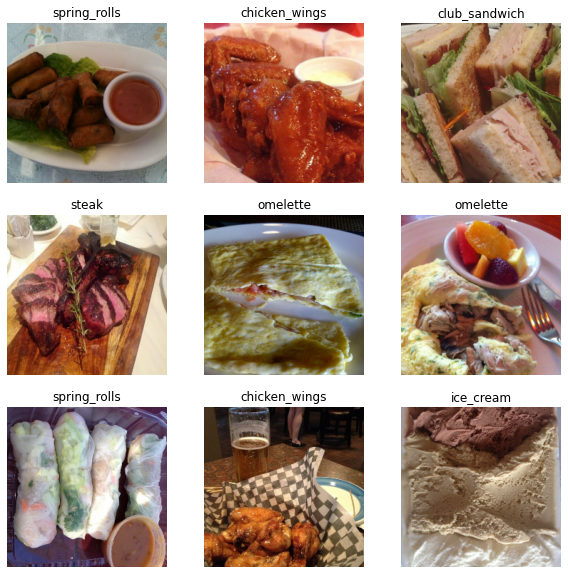

In [14]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# Build Model and Train

Using Transfer Learning (MobileNet V2)

In [15]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

base_model.trainable = False

# Let's take a look at the base model architecture
base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

9412608/9406464 [==============================] - 0s 0us/step
(64, 7, 7, 1280)
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
epochs=3
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
    )

Epoch 1/3
250/250 [==============================] - 542s 2s/step - loss: 1.2262 - accuracy: 0.6472 - val_loss: 0.7956 - val_accuracy: 0.7760
Epoch 2/3
250/250 [==============================] - 570s 2s/step - loss: 0.7203 - accuracy: 0.7832 - val_loss: 0.7189 - val_accuracy: 0.7930
Epoch 3/3
250/250 [==============================] - 605s 2s/step - loss: 0.6332 - accuracy: 0.8071 - val_loss: 0.6982 - val_accuracy: 0.7993


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                25620 

# Visualization Training

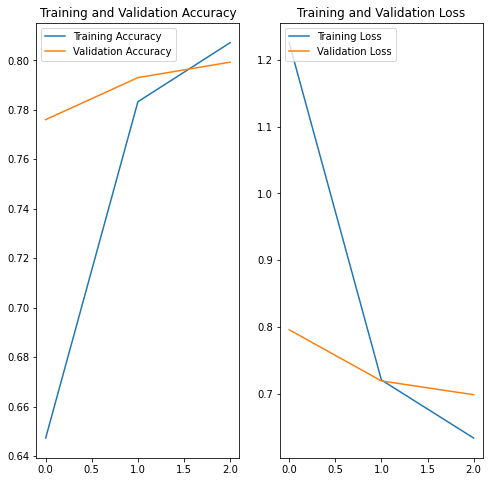

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

# Make Prediction

In [20]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  img = fn
img_path = '/content/' + img

Saving spagheti-966389_1920.jpg to spagheti-966389_1920.jpg


In [21]:
img = keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

This image most likely belongs to spaghetti with a 98.06 percent confidence.


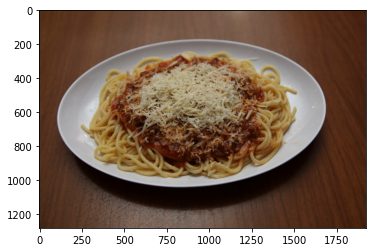

In [22]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.show()

# Food Calories

In [23]:
food_dict = {
	"caesar_salad": 44,
	"chicken_wings": 220,
	"club_sandwich": 221,
	"cup_cakes": 305,
	"donuts": 452,
	"dumplings": 112,
	"french_fries": 165,
	"fried_rice": 163,	
	"hamburger": 294,
	"ice_cream": 208,
	"omelette": 154,
	"onion_rings": 411,
  "pizza": 266,
  "spaghetti": 157,
	"spring_rolls": 153,
	"pancakes": 227,
	"steak": 271,
	"sushi": 143,
	"takoyaki": 175,
	"waffles": 291,	
}

In [24]:
food_name = class_names[np.argmax(score)]

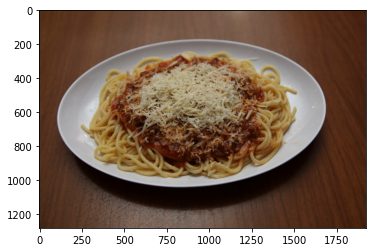

This Food (spaghetti) has 157 calories.


In [26]:
imgplot = plt.imshow(img)
plt.show()

print(
    'This Food ({}) has {} calories.'
    .format(food_name, food_dict[food_name])
    )

# Save Model

In [27]:
print(model.input)
print(model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), name='dense/BiasAdd:0', description="created by layer 'dense'")


In [28]:
export_dir = 'saved_model/1'
model.save(export_dir)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/1/assets


## Convert to TFLite

In [29]:
# Select mode of optimization
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [30]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) 

# Set the optimzations
converter.optimizations = [optimization] 

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert() 

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

2673712